# Piecewise linear functions on triangulations

We test the two OMP algorithm on functions in two dimensions, $[0,1]^2$, that is we take $V = H_0^1([0,1]^2)$. We are approximating solutions $u(a(y))$ of the diffusion

We consider a dyadic level-$N$ uniform grid with spacing $\Delta x_{(N)} = 2^{-N}$. The solution is computed on the regular triangulation on this grid, evidently with $h=2^{-N}$. The field $a$ is a pw-constant function on a typically coarser grid, with spacing say $2^{-N_a}$, where $N_a \le N$. 

The dictionary $\mathcal{D}$ for the OMP algorithms consists of the representers of local integration, where the kernel for the local integration are hat-functions. The hat functions we consider are on the squares of size $2^{-N_\mathrm{hat}}$, again with $N_{\mathrm{hat}} \le N$.

That is, if $\mathrm{Hat}_{i,j}$ is the pw linear hat function on the square $[i 2^{-N_{\mathrm{hat}}}, (i+1) 2^{-N_{\mathrm{hat}}}) \times [j 2^{-N_{\mathrm{hat}}}, (j+1) 2^{-N_{\mathrm{hat}}})$, then $\mathcal{D}^{\mathrm{hat}}$ is the collection of functions $\omega_{i,j}$ such that
$$
\langle f, \omega_{i,j}\rangle_{H_0^1} = \int_{[0,1]^2} f \, \mathrm{Hat}_{i,j} \, \mathrm{d}x
$$

The measurement space $W_m$ is constructed such as to minimised $\beta(V_n, W_m)$, where $V_n$ is the provided approximation space. In this case $V_n$ is the space of random the solutions $u(a(y))$

In [1]:
import numpy as np
import scipy as sp
import math
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

import sys
sys.path.append("../../")
import pyApproxTools as pat
importlib.reload(pat)

%matplotlib inline

### Now we are going to set up a full dictionary of local integration points


In [2]:
fem_div = 7
field_div = 2

n = 50

np.random.seed(3)

Vn_sin = pat.make_pw_sin_basis(div=fem_div)
Vn_red, fields = pat.make_pw_reduced_basis(n, field_div=field_div, fem_div=fem_div)
Vn_red_o = Vn_red.orthonormalise()

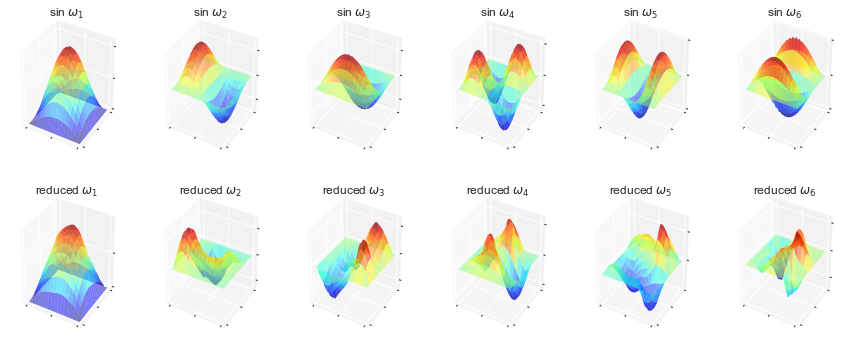

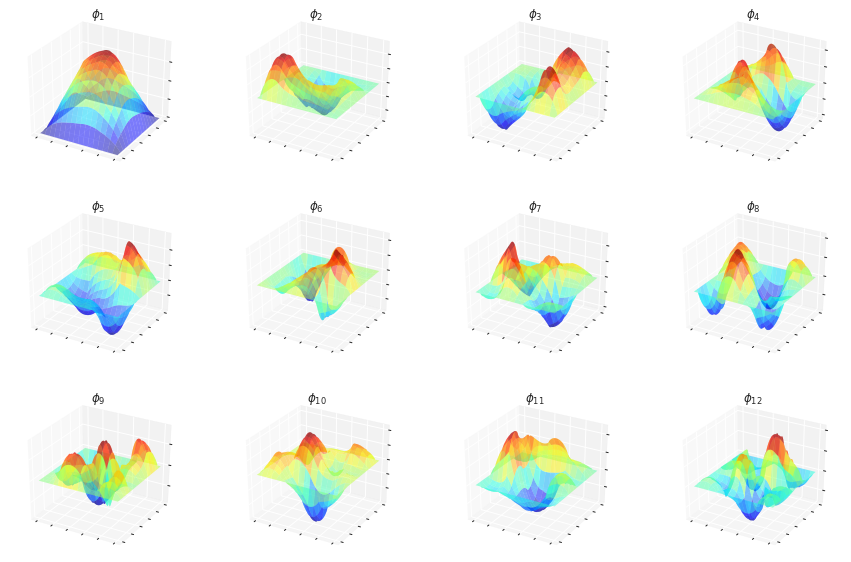

In [3]:
# Lets plot our measurment locations
fig = plt.figure(figsize=(15, 6))

disp = 6
for i in range(disp):
    ax1 = fig.add_subplot(2, disp, i+1, projection='3d')
    Vn_sin.vecs[i].plot(ax1, title=r'sin $\omega_{{{0}}}$'.format(i+1))
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_zticklabels([])
    ax1.set(xlabel='', ylabel='')
    ax2 = fig.add_subplot(2, disp, i+1+disp, projection='3d')
    Vn_red_o.vecs[i].plot(ax2, title=r'reduced $\omega_{{{0}}}$'.format(i+1))
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    ax2.set_zticklabels([])
    ax2.set(xlabel='', ylabel='')
plt.show()

fig = plt.figure(figsize=(15,10))
disp = 12
for i in range(disp):
    ax1 = fig.add_subplot(3, disp/3, i+1, projection='3d')
    Vn_red_o.vecs[i].plot(ax1, title=r'$\phi_{{{0}}}$'.format(i+1))
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_zticklabels([])
    ax1.set(xlabel='', ylabel='')
plt.savefig('Vn_RedBasisOrtho.pdf')
plt.show()

### Now examine the convergence of projections against a "snapshot" reduced basis and a sinusoidal basis

The idea being that we are examining the balance of both $\mu(V_n, W_m)$ and $\varepsilon$ with the two choices of approximation space

In [4]:
num_sol = 10
sols, sol_fields = pat.make_pw_reduced_basis(num_sol, field_div=field_div, fem_div=fem_div)
soln_col = sols.vecs

dist_sin = np.zeros((num_sol, n))
dist_red = np.zeros((num_sol, n))

for i, v in enumerate(soln_col):
    for j in range(1,n):
        P_v_sin = Vn_sin.subspace(slice(0,j)).project(v)
        P_v_red = Vn_red.subspace(slice(0,j)).project(v)
        
        dist_sin[i, j] = (v - P_v_sin).norm()
        dist_red[i, j] = (v - P_v_red).norm()

### Now we compare the OMP algorithm against both...  For now we do it here with n=20

In [5]:
width = 2

n = 20
m=150

print('Construct dictionary of local averages...')
D = pat.make_pw_hat_rep_dict(fem_div, width=width)

print('Worst-case greedy basis construction...')

wcbc = pat.WorstCaseOMP(D, Vn_sin.subspace(slice(0,20)), Wm=pat.PWBasis(), verbose=True)
Wm_wc_sin = wcbc.construct_to_m(m)
Wm_wc_sin_o = Wm_wc_sin.orthonormalise()

wcbc = pat.WorstCaseOMP(D, Vn_red_o.subspace(slice(0,20)), Wm=pat.PWBasis(), verbose=True)
Wm_wc_red = wcbc.construct_to_m(m)
Wm_wc_red_o = Wm_wc_red.orthonormalise()

bs_wc_sin = np.zeros(m)
bs_wc_red = np.zeros(m)

# For efficiency it makes sense to compute the basis pair and the associated
# cross-gramian only once, then sub sample it as we grow m...
BP_wc_sin_l = pat.BasisPair(Wm_wc_sin_o, Vn_sin.subspace(slice(0,20)))
BP_wc_red_l = pat.BasisPair(Wm_wc_red_o, Vn_red_o.subspace(slice(0,20)))

for i in range(n, m):
    BP_wc_sin =  BP_wc_sin_l.subspace(Wm_indices=slice(0,i))
    BP_wc_red =  BP_wc_red_l.subspace(Wm_indices=slice(0,i))

    bs_wc_sin[i] = BP_wc_sin.beta()
    bs_wc_red[i] = BP_wc_red.beta()

Construct dictionary of local averages...
Worst-case greedy basis construction...
i 	 || P_Vn (w - P_Wm w) ||
1 : 	 3638 	 0.15896129284882923
2 : 	 2882 	 0.28023384079915703
3 : 	 2789 	 0.34160899591679844
4 : 	 1244 	 0.41428868506194116
5 : 	 1211 	 0.4647186623777616
6 : 	 2066 	 0.3426552966965046
7 : 	 659 	 0.4363310880469529
8 : 	 3481 	 0.34835070684181346
9 : 	 3244 	 0.3575170783532212
10 : 	 683 	 0.3199560488142767
11 : 	 1845 	 0.315746212933439
12 : 	 521 	 0.2972234012732917
13 : 	 2150 	 0.3638279257410446
14 : 	 3269 	 0.3134171003159282
15 : 	 2968 	 0.3075979847611519
16 : 	 2434 	 0.25716727935280814
17 : 	 608 	 0.40812495629783746
18 : 	 1350 	 0.32963243763672256
19 : 	 1505 	 0.34860178976099243
20 : 	 763 	 0.39180571250652135
21 : 	 2548 	 0.26545848041915776
22 : 	 1456 	 0.28162322197276335
23 : 	 2512 	 0.2465876496268674
24 : 	 3379 	 0.30016889465976143
25 : 	 1551 	 0.4183489284436026
26 : 	 3472 	 0.27429577016515017
27 : 	 1995 	 0.22583464149014879

92 : 	 3046 	 0.10757491762715134
93 : 	 3380 	 0.07733908931424315
94 : 	 1659 	 0.10290689304399504
95 : 	 2750 	 0.07899294617078945
96 : 	 2592 	 0.12601042419253985
97 : 	 1804 	 0.07882370230839092
98 : 	 654 	 0.08031221822721063
99 : 	 2850 	 0.07310034198052694
100 : 	 2704 	 0.08320994018238492
101 : 	 965 	 0.09948426938679804
102 : 	 995 	 0.07424109738912127
103 : 	 2974 	 0.10519664671395625
104 : 	 2676 	 0.07879610495443518
105 : 	 3707 	 0.0994844936563254
106 : 	 913 	 0.07250128857305185
107 : 	 3738 	 0.09277890425084562
108 : 	 2252 	 0.1273989441541033
109 : 	 1422 	 0.09589060083111263
110 : 	 950 	 0.07859445816837216
111 : 	 210 	 0.08340656980577431
112 : 	 1264 	 0.09606863666176266
113 : 	 1445 	 0.06602880863193598
114 : 	 1228 	 0.0963625867020627
115 : 	 798 	 0.07807917358349309
116 : 	 2003 	 0.07958752266021187
117 : 	 3020 	 0.0787746946507061
118 : 	 299 	 0.08132198645593834
119 : 	 454 	 0.055894810138671217
120 : 	 619 	 0.06525869797297702
121 : 

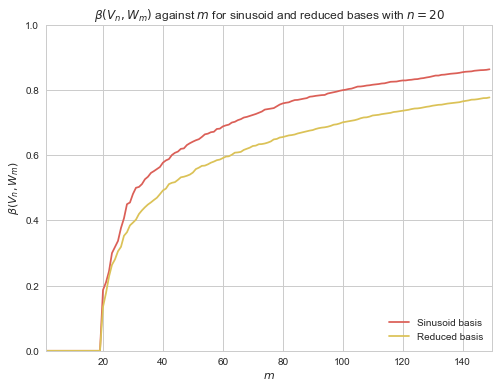

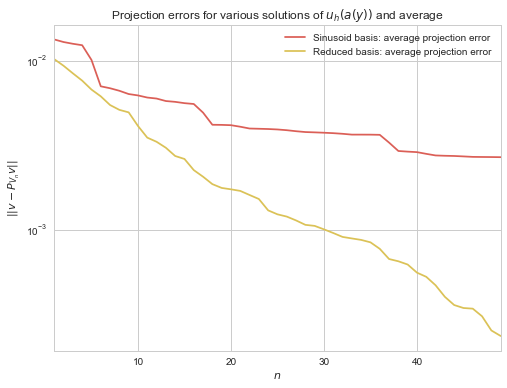

In [7]:
sns.set_style('whitegrid')
line_style = ['-', '--', ':', '-', '-.']

sns.set_palette("hls", 8)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, title=r'$\beta(V_n, W_m)$ against $m$ for sinusoid and reduced bases with $n=20$')#, title=r'$\beta(V_n, W_m)$ against $m$ for various $n$')
    
plt.plot(range(m), bs_wc_sin, label=r'Sinusoid basis')
plt.plot(range(m), bs_wc_red, label=r'Reduced basis')
ax.set(xlim=[1,m], ylim=[0,1], xlabel=r'$m$', ylabel=r'$\beta(V_n, W_m)$')
ax.legend(loc=4)
plt.savefig('SinVsRedBeta.pdf')
plt.show()  

n = 50
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, title=r'Projection errors for various solutions of $u_h(a(y))$ and average')

cp = sns.color_palette("hls", 8)
#plt.semilogy(range(1,n), dist_sin[0, 1:], ':', color=cp[0], linewidth=1, label=r'Sinusois basis: proj error single vec')
#for i, v in enumerate(soln_col[1:]):
#    plt.semilogy(range(1,n), dist_sin[i, 1:], ':', color=cp[0], linewidth=1)
plt.semilogy(range(1,n), dist_sin[:,1:].mean(axis=0), color=cp[0], label=r'Sinusoid basis: average projection error')
    
#plt.semilogy(range(1,n), dist_red[0, 1:], ':', color=cp[1], linewidth=1, label=r'Reduced basis: proj error single vec')
#for i, v in enumerate(soln_col[1:]):
#    plt.semilogy(range(1,n), dist_red[i, 1:], ':', color=cp[1], linewidth=1)
plt.semilogy(range(1,n), dist_red[:,1:].mean(axis=0), color=cp[1], label=r'Reduced basis: average projection error')
ax.set(xlim=[1,n-1], xlabel=r'$n$', ylabel=r'$||v - P_{V_n} v ||$')
ax.legend(loc=1)
plt.savefig('SinVsRedProjErr.pdf')
plt.show()  

In [ ]:
fig = plt.figure(figsize=(15, 24))

disp = 48
for i in range(disp):
    ax1 = fig.add_subplot(8, disp/8, i+1, projection='3d')
    Wm_wc_red_o.vecs[i].plot(ax1, title=r'meas$')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_zticklabels([])
    ax1.set(xlabel='', ylabel='')
plt.show()

fig = plt.figure(figsize=(8, 6))

ax2 = fig.add_subplot(1,1,1, projection='3d')
Wm_wc_sin_o.reconstruct(np.ones(m)).plot(ax2, title=r'meas total sin')
plt.show()
fig = plt.figure(figsize=(8, 6))
ax3 = fig.add_subplot(1,1,1, projection='3d')
Wm_wc_red_o.reconstruct(np.ones(m)).plot(ax3, title=r'meas total red')
plt.show()